<a href="https://colab.research.google.com/github/markisabelle/Data-Analytics-Projects/blob/main/Funnel_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

df = pd.read_csv('raw_data.csv')

In [10]:
df

,user_id,date,category,device,event_type
0,956977,2020-10-04 00:00:00,Office Supplies,desktop,visit
1,941383,2020-10-25 00:00:00,Furniture,mobile,visit
2,864077,2021-11-19 00:00:00,Technology,mobile,visit
3,689619,2022-02-05 00:00:00,Technology,desktop,visit
4,689619,2022-02-07 00:00:00,Technology,desktop,view
...,...,...,...,...,...
434263,504193,2022-05-26 00:00:00,Office Supplies,mobile,visit
434264,504193,2022-05-31 00:00:00,Office Supplies,mobile,view
434265,504193,2022-06-06 00:00:00,Office Supplies,mobile,add_to_cart
434266,997436,2021-07-26 00:00:00,Furniture,mobile,visit


In [14]:
# Getting the count at each stage
flow_count = [
	df[df['event_type'] == 'visit'].shape[0],
    df[df['event_type'] == 'view'].shape[0],
    df[df['event_type'] == 'add_to_cart'].shape[0],
    df[df['event_type'] == 'purchase'].shape[0]
]


# Plotting the stages as a funnel
stages = ['Visits', 'view product', 'add to cart', 'puchased product']
fig = go.Figure(go.Funnel(x = flow_count, y = stages, textinfo = 'value+percent initial'))
fig.show()



*   78% of the 192k visitors viewed a product
*   41% of them added products to their cart
* 6% of the visitors purchased a product



## **Interpreting Drop-Off**

In [21]:
def stage_loss(data_df, show_all = False):
  # data_df is expected to have two columns: 'event_type' and 'count'
  values = data_df.values.tolist()
  max_percentage_drop = -1.0 # Initialize with a value lower than any possible percentage drop
  at_stage = None # Initialize at_stage

  # iterating through each row
  for index in range(len(values) - 1):

    # extracting the current event and the next event
    start_event = values[index][0]
    next_event = values[index + 1][0]

    # extracting the count of the current event and the next event
    start_event_count = values[index][1]
    next_event_count = values[index +1][1]
    stage = f"{start_event} -> {next_event}"

    if start_event_count == 0: # Avoid division by zero
        current_percentage_drop = 0
    else:
        current_percentage_drop = (start_event_count - next_event_count) / start_event_count

    # checking if the calculated percentage drop is higher than the current max
    if current_percentage_drop > max_percentage_drop:
      max_percentage_drop = current_percentage_drop
      at_stage = stage
    if show_all:
      print(f'The percentage drop from {stage} is {round(100 * current_percentage_drop, 1)}%')

  return at_stage, max_percentage_drop

# Create a DataFrame from 'stages' and 'flow_count' to correctly use stage_loss
data_for_stage_loss = pd.DataFrame({
    'event_type': stages,
    'count': flow_count
})

stage, percent = stage_loss(data_for_stage_loss)
print(f"The largest drop-off occurs at the stage: '{stage}' with a percentage loss of {round(100 * percent, 2)}%")

The largest drop-off occurs at the stage: 'add to cart -> puchased product' with a percentage loss of 85.06%


The largest drop-off occurs at the stage: **'add to cart -> puchased product'** with a *percentage loss* of **85.06%**

Possible reasons:

1.   Not knowing the value of the products (increase price to show high-value)
2.   Retention rates are low (provided warranty programs or buy-back guarantees for greater trust)
3. Promotions are weak/none (create a better promational market)



## **Visit to Purchase Time**

In [30]:
# converting the unique event types into a list and remove the visit event type
distinct_events = df['event_type'].unique().tolist()
distinct_events.remove("visit")

# creating a dataframe with only visits (used to compare against all other event types)
visits = df[df['event_type'] == 'visit'][['user_id', 'date', 'event_type']]
dataframes = {} # Changed to a dictionary to store dataframes by event type

# looping through each event type
for event in distinct_events:
  # extracting data for the current event type
  other_event = df[df['event_type'] == event][['user_id', 'date', 'event_type']]

  # we want to see the dates for when the user visited and the current event,
  # so let's join the data on the user_id
  comparison = visits.merge(other_event, on='user_id', suffixes=('','_2'))

  # Convert date columns to datetime objects before calculating difference
  comparison['date'] = pd.to_datetime(comparison['date'])
  comparison['date_2'] = pd.to_datetime(comparison['date_2'])

  # calculating the days elapsed by finding the difference between
  # visit date and the next event date (ex: purchase_date - visit_date)
  comparison['days_elapsed'] = (comparison['date_2'] - comparison['date']).dt.days
  # comparison['days_elapsed'] = comparison['days_elapsed'].apply(lambda value: int(str(value).split()[0])) # This line is incorrect and will be removed
  dataframes[event] = comparison # Store the comparison DataFrame in the dictionary

# Assigning the dataframes for specific event types from the dictionary
views = dataframes.get('view')
cart = dataframes.get('add_to_cart')
purchase = dataframes.get('purchase')

# The following block of code is removed as the variable 'event' would only hold
# the last value from the loop ('purchase'), making the assignments incorrect.
# If a specific 'stats_frame' is needed, it should be explicitly chosen from views, cart, or purchase.
if event == "view":
  stats_frame = views
elif event == "add_to_cart":
  stats_frame = cart
elif event == "purchase":
  stats_frame = purchase

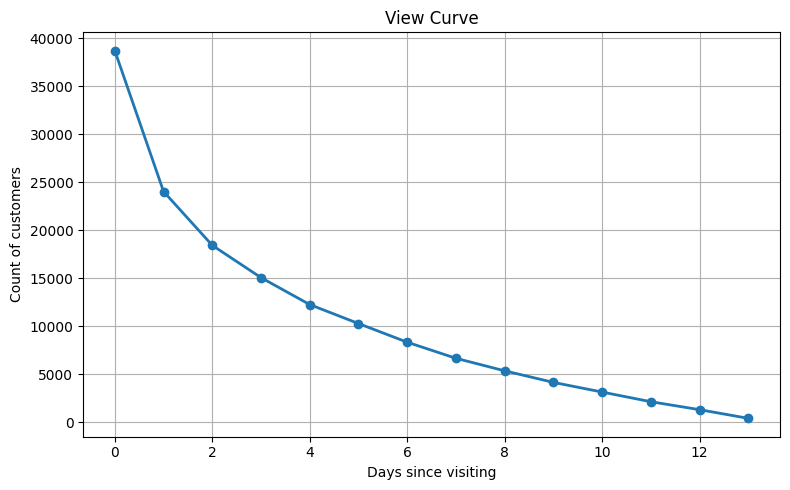

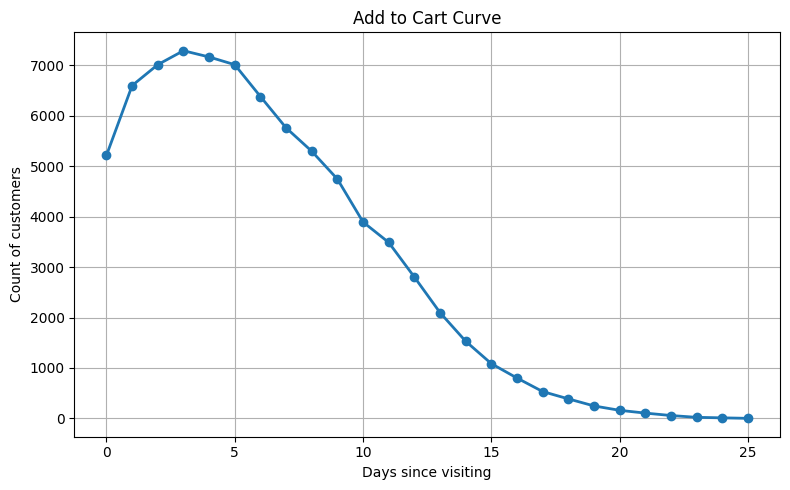

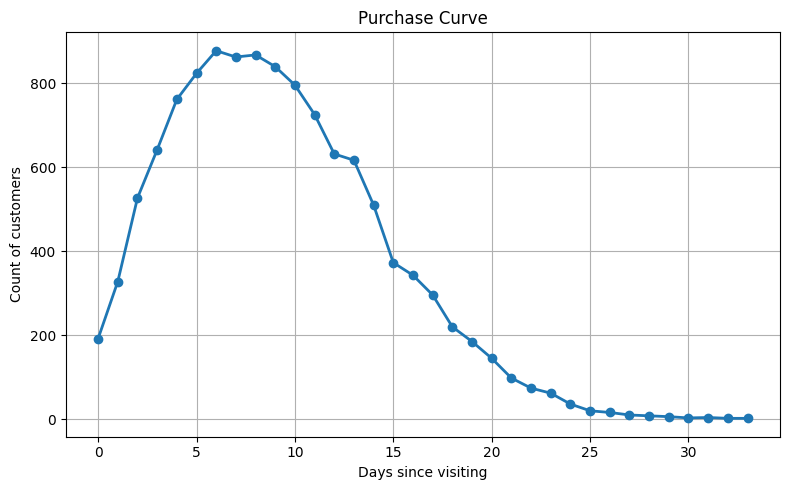

In [33]:
import matplotlib.pyplot as plt

# Define curves and labels
curves = {
    'View': view_curve,
    'Add to Cart': cart_curve,
    'Purchase': purchase_curve
}

for label, curve in curves.items():
    plt.figure(figsize=(8, 5))
    plt.plot(
        curve['days_elapsed'],
        curve['count'],
        marker='o',
        linewidth=2,
        label=label
    )
    plt.title(f'{label} Curve')
    plt.xlabel("Days since visiting")
    plt.ylabel("Count of customers")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
